In [1]:
import numpy as np
import tensorflow as tf
import keras
from tensorflow.keras import layers
#import  tensorflow_addons as tfa

2024-09-24 23:56:42.376414: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-24 23:56:43.108172: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-24 23:56:43.577175: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-24 23:56:46.198687: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-24 23:56:51.349379: W tensorflow/compiler/tf2

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


In [3]:
batch_size  = 256
image_size = 224
patch_size = 32

num_patches = (image_size//patch_size)**2  # 49

projection_dim = 64
num_heads = 4

transformer_units = [
    projection_dim * 2,
    projection_dim,
]

transformer_layers = 12

mlp_head_units = [2048, 1024,]

In [4]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip('horizontal'),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor= 0.2),
    ],
    name = 'data_augmentation',
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

2024-09-24 23:57:08.484784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79078 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:c8:00.0, compute capability: 8.0


In [5]:
def mlp(x, hidden_units, dropout_rate):
  for units in hidden_units:
    x = layers.Dense(units, activation=tf.nn.gelu)(x)
    x = layers.Dropout(dropout_rate)(x)
  return x

In [6]:
class Patches(layers.Layer):
  def __init__(self, patch_size):
    super().__init__()
    self.patch_size = patch_size

  def call(self, images):
    batch_size = tf.shape(images)[0]
    # Patchify the images and flatten it
    patches = tf.image.extract_patches(
        images = images,
        sizes = [1, self.patch_size, self.patch_size, 1],
        strides=[1, self.patch_size, self.patch_size, 1],
        rates = [1,1,1,1],
        padding = "VALID",
    )
    patch_dims = patches.shape[-1]
    #print(f"paches shape: {patches.shape}") #(1,7,7,3072)
    #print(patch_dims) #(3072)
    patches = tf.reshape(patches, [batch_size, -1, patch_dims])
    #print(f"paches shape: {patches.shape}") #(1,49,3072)
    return patches

(32, 32, 3)
(1, 224, 224, 3)
paches shape: (1, 49, 3072)


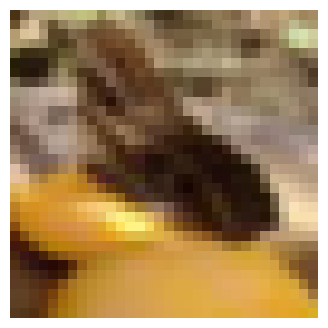

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
print(image.shape) #(32, 32, 3)
plt.imshow(image.astype("uint8"))
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
print(resized_image.shape) # (1, 224, 224, 3)
#plt.imshow(image.astype("uint8"))
#plt.axis("off")

patches = Patches(patch_size)(resized_image)
print(f"paches shape: {patches.shape}")

Image size: 224 X 224
Patch size: 32 X 32
Patches per image: 49
Elements per patch: 3072
(49, 3072)


'\ntf.Tensor(\n[[[ 37.000046  75.000015  21.000051]\n  [ 37.428608  74.57145   21.285763]\n  [ 37.85718   74.142876  21.571472]\n  ...\n  [121.99994  145.99994   93.99994 ]\n  [121.99994  145.99994   93.99994 ]\n  [121.99994  145.99994   93.99994 ]]\n\n [[ 39.857174  76.857155  24.571465]\n  [ 40.102066  76.346954  24.653093]\n  [ 40.346966  75.83675   24.734724]\n  ...\n  [117.42853  141.99997   89.71425 ]\n  [117.42853  141.99997   89.71425 ]\n  [117.42853  141.99997   89.71425 ]]\n\n [[ 42.714306  78.71429   28.142876]\n  [ 42.775524  78.12245   28.020426]\n  [ 42.83675   77.53062   27.897976]\n  ...\n  [112.85712  137.99997   85.42854 ]\n  [112.85712  137.99997   85.42854 ]\n  [112.85712  137.99997   85.42854 ]]\n\n ...\n\n [[ 60.000015  91.000015  52.000015]\n  [ 61.142868  92.00001   53.142868]\n  [ 62.28572   93.00001   54.28572 ]\n  ...\n  [ 71.        92.        47.      ]\n  [ 71.        92.        47.      ]\n  [ 71.        92.        47.      ]]\n\n [[ 60.000015  91.000015 

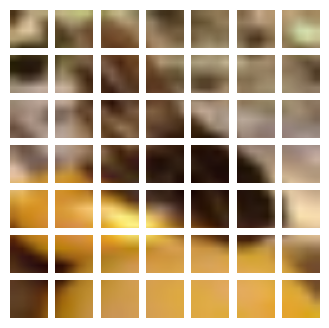

In [8]:
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
print(patches[0].shape)
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
    #print(patch_img)
"""
tf.Tensor(
[[[ 37.000046  75.000015  21.000051]
  [ 37.428608  74.57145   21.285763]
  [ 37.85718   74.142876  21.571472]
  ...
  [121.99994  145.99994   93.99994 ]
  [121.99994  145.99994   93.99994 ]
  [121.99994  145.99994   93.99994 ]]

 [[ 39.857174  76.857155  24.571465]
  [ 40.102066  76.346954  24.653093]
  [ 40.346966  75.83675   24.734724]
  ...
  [117.42853  141.99997   89.71425 ]
  [117.42853  141.99997   89.71425 ]
  [117.42853  141.99997   89.71425 ]]

 [[ 42.714306  78.71429   28.142876]
  [ 42.775524  78.12245   28.020426]
  [ 42.83675   77.53062   27.897976]
  ...
  [112.85712  137.99997   85.42854 ]
  [112.85712  137.99997   85.42854 ]
  [112.85712  137.99997   85.42854 ]]

 ...

 [[ 60.000015  91.000015  52.000015]
  [ 61.142868  92.00001   53.142868]
  [ 62.28572   93.00001   54.28572 ]
  ...
  [ 71.        92.        47.      ]
  [ 71.        92.        47.      ]
  [ 71.        92.        47.      ]]

 [[ 60.000015  91.000015  52.000015]
  [ 61.142868  92.00001   53.142868]
  [ 62.28572   93.00001   54.28572 ]
  ...
  [ 71.        92.        47.      ]
  [ 71.        92.        47.      ]
  [ 71.        92.        47.      ]]

 [[ 60.000015  91.000015  52.000015]
  [ 61.142868  92.00001   53.142868]
  [ 62.28572   93.00001   54.28572 ]
  ...
  [ 71.        92.        47.      ]
  [ 71.        92.        47.      ]
  [ 71.        92.        47.      ]]], shape=(32, 32, 3), dtype=float32)
"""

In [9]:
# the parameter size of PatchEncoder layer :   199808
# position_embedding+linear layer + bias: 49 * 64 + 3072 * 64 +  64 = 199808
# Position Embedding (49 * 64)
# Linear Layer (3072 * 64) + bias (64)
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        #print(f"positions: {positions}, positions size: {len(positions)}")
        #print(f"patches' shape: {patch.shape}")
        projected_patches = self.projection(patch)
        #print(f"projected_patches.shape: {projected_patches.shape}")
        encoded = projected_patches + self.position_embedding(positions)
        #print(f"encoded.shape: {encoded.shape}")
        return encoded

In [10]:
inputs = keras.Input(shape=input_shape)
augmented = data_augmentation(inputs)
patches = Patches(patch_size)(augmented)
print(f"patches.shape: {patches.shape}")
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
print(f"encoded_patches: {encoded_patches}")
for _ in range(1):
  x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  print(f"x1.shape: {x1.shape}")
  attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
  )(x1, x1)
  print(f"attention_output.shape: {attention_output.shape}")
  x2 = layers.Add()([attention_output, encoded_patches])
  print(f"x2.shape: {x2.shape}")
  x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
  print(f"x3.shape: {x3.shape}")
  x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
  print(f"x3.shape: {x3.shape}")
  encoded_patches = layers.Add()([x3, x2])

print(f"enconded_patches_size: {encoded_patches.shape}")

representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)

print(f"representation.shape: {representation.shape}")

features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
print(f"features.shape: {features.shape}")

logits = layers.Dense(num_classes)(features)
print(f"logits shape: {logits.shape}")

patches.shape: (None, None, 3072)


W0000 00:00:1727189839.234284   37134 gpu_backend_lib.cc:593] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.3
  /usr/local/cuda
  /scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment variable XLA_FLAGS=--xla_gpu_cuda_data_dir=/path/to/cuda will work.


encoded_patches: <KerasTensor shape=(None, 49, 64), dtype=float32, sparse=False, name=keras_tensor_10>
x1.shape: (None, 49, 64)
attention_output.shape: (None, 49, 64)
x2.shape: (None, 49, 64)
x3.shape: (None, 49, 64)
x3.shape: (None, 49, 64)
enconded_patches_size: (None, 49, 64)
representation.shape: (None, 3136)
features.shape: (None, 1024)
logits shape: (None, 100)


In [11]:
def vit():
  inputs = layers.Input(shape=input_shape)
  # Augment datas
  augmented = data_augmentation(inputs)
  patches = Patches(patch_size)(augmented)

  encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

  for _ in range(transformer_layers):

    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    attention_output = layers.MultiHeadAttention(
        num_heads = num_heads, key_dim = projection_dim, dropout=0.1
    )(x1, x1)

    x2 = layers.Add()([attention_output,encoded_patches])

    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

    x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

    encoded_patches = layers.Add()([x3,x2])

  print(f"encoded_patches.shape: {encoded_patches.shape}") #(None, 49, 64)
  representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
  representation = layers.Flatten()(representation)
  print(f"Flatten_representation.shape: {representation.shape}") #(None, 3136)
  representation = layers.Dropout(0.5)(representation)

  features = mlp(representation, hidden_units=mlp_head_units, dropout_rate = 0.5)

  logits = layers.Dense(num_classes)(features)

  model = keras.Model(inputs=inputs, outputs=logits)
  return model

In [12]:
model = vit()
model.summary()

encoded_patches.shape: (None, 49, 64)
Flatten_representation.shape: (None, 3136)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 32, 32, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 224, 224,  │          7 │ input_layer_2[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_2 (Patches) │ (None, None,      │          0 │ data_augmentatio… │
│                     │ 3072)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_1     │ (None, 49, 64)    │    199,808 │ patches_2[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ patch_encoder_1[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 49, 128)   │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 49, 64)    │      8,256 │ dropout_7[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 49, 64)    │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 49, 64)    │          0 │ dropout_8[0][0],  │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 49, 64)    │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 49, 64)    │          0 │ multi_head_atten… │
│                     │                   │            │ add_3[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 49, 64)    │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 49, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,823,595 (37.47 MB)

 Trainable params: 9,823,588 (37.47 MB)

 Non-trainable params: 7 (32.00 B)

In [13]:
num_epochs = 10
weight_decay = 0.001
learning_rate = 0.001

#optimizer = tfa.optimizers.AdamW(
optimizer = tf.keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
)

model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
)

history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1
)


Epoch 1/10


W0000 00:00:1727189868.381031   37122 gpu_backend_lib.cc:631] libdevice is required by this HLO module but was not found at ./libdevice.10.bc
error: libdevice not found at ./libdevice.10.bc
2024-09-24 23:57:48.432258: E tensorflow/compiler/mlir/tools/kernel_gen/tf_framework_c_interface.cc:228] INTERNAL: Generating device code failed.
2024-09-24 23:57:48.432902: W tensorflow/core/framework/op_kernel.cc:1828] UNKNOWN: JIT compilation failed.
2024-09-24 23:57:48.432946: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: UNKNOWN: JIT compilation failed.
	 [[{{function_node __inference_one_step_on_data_47473}}{{node functional_1_1/data_augmentation_1/normalization_1/Sqrt}}]]
2024-09-24 23:57:48.432958: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 5414045183808140862
W0000 00:00:1727189868.605189   37181 gpu_backend_lib.cc:631] libdevice is required by this HLO module but was not found at ./li

UnknownError: Graph execution error:

Detected at node functional_1_1/data_augmentation_1/normalization_1/Sqrt defined at (most recent call last):
  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/runpy.py", line 86, in _run_code

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/traitlets/config/application.py", line 1075, in launch_instance

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 701, in start

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 205, in start

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 534, in dispatch_queue

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 523, in process_one

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 429, in dispatch_shell

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 767, in execute_request

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 429, in do_execute

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 549, in run_cell

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3075, in run_cell

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3130, in _run_cell

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 128, in _pseudo_sync_runner

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3334, in run_cell_async

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3517, in run_ast_nodes

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3577, in run_code

  File "/tmp/ipykernel_36807/1047066900.py", line 19, in <module>

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 320, in fit

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 121, in one_step_on_iterator

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 108, in one_step_on_data

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/backend/tensorflow/trainer.py", line 51, in train_step

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/models/functional.py", line 175, in call

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/models/functional.py", line 560, in call

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/models/sequential.py", line 212, in call

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/models/functional.py", line 175, in call

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/models/functional.py", line 560, in call

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/layers/preprocessing/tf_data_layer.py", line 43, in __call__

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/layers/preprocessing/normalization.py", line 327, in call

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/backend/tensorflow/sparse.py", line 387, in sparse_wrapper

  File "/scratch/qualis/miniconda3/envs/vit2/lib/python3.10/site-packages/keras/src/backend/tensorflow/numpy.py", line 2309, in sqrt

JIT compilation failed.
	 [[{{node functional_1_1/data_augmentation_1/normalization_1/Sqrt}}]] [Op:__inference_one_step_on_iterator_48802]

In [ ]:
_, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

In [ ]:
def plot_history(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("top-5-accuracy")